In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy.stats import zscore



def get_windows(job,n_neighbors):
    '''
    For each region and each individual cell in dataset, return the indices of the nearest neighbors.
    
    'job:  meta data containing the start time,index of region, region name, indices of region in original dataframe
    n_neighbors:  the number of neighbors to find for each cell
    '''
    start_time, idx, tissue_name, indices = job
    job_start = time.time()
    
    print("Starting:", str(idx + 1) + '/' + str(len(exps)), ': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X, Y]].values

#     fit = NearestNeighbors(n_neighbors=n_neighbors+1).fit(tissue[[X,Y]].values)
    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X, Y]].values)
    m = fit.kneighbors(to_fit)
#     m = m[0][:,1:], m[1][:,1:]
    m = m[0], m[1]
    

    # sort_neighbors
    args = m[0].argsort(axis=1)
    add = np.arange(m[1].shape[0]) * m[1].shape[1]
    sorted_indices = m[1].flatten()[args + add[:, None]]

    neighbors = tissue.index.values[sorted_indices]
   
    end_time = time.time()
   
    print("Finishing:", str(idx + 1) + '/' + str(len(exps)), ': ' + exps[idx], end_time - job_start, end_time - start_time)
    return neighbors.astype(np.int32)

In [2]:
cells = pd.read_csv('Cell-ID_by-islet.csv')
cts = ['α cell', 'δ cell', 'β cell', 'γ cell', 'ɛ cell', 'T cell', 'Macrophage', 'Other immune cell', 'EC', 'Pericyte']
cells = cells.drop(['B cell', 'Arg1 Positive Classification', 'Ki67 Positive Classification'], axis=1)
cells['T cell'] = ((cells['Helper T cell'] + cells['Cytotoxic T cell'] + cells['Inactive T cell'] + cells['T cell']) >= 1) + 0
cells['Macrophage'] = ((cells['M1 mac'] + cells['M2 mac'] + cells['M1/M2 mac'] + cells['Other mac'] + cells['Macrophage']) >= 1) + 0
cells['EC'] = ((cells['HLA-DR+ EC'] + cells['CD34+ EC'] + cells['HLA-DR+ CD34+ EC'] + cells['EC']) >= 1) + 0
cells = cells.drop(['Helper T cell', 'Cytotoxic T cell', 'Inactive T cell', 'M1 mac', 'M2 mac', 'M1/M2 mac', 'Other mac', 'HLA-DR+ EC', 'CD34+ EC', 'HLA-DR+ CD34+ EC'], axis=1)
# cells = cells[['Donor', 'Group', 'Islet', 'Cell', 'Cell ID', 'Cell Name', 'XMin', 'Y'] + cts],
def annotate(row):
    for ct in cts:
        if row[ct] == 1:
            return ct
    return 0
cells['Cell Name'] = cells.apply(lambda r: annotate(r), axis=1)
cells = cells[cells['Cell Name'] != 0]
cells = cells[['Donor', 'Islet', 'Cell', 'Group', 'Cell ID', 'XMin', 'XMax', 'YMin', 'YMax', 'α cell', 'δ cell', 'β cell', 'γ cell', 'ɛ cell', 'Other immune cell', 'Pericyte', 'T cell', 'Macrophage', 'EC']]
cells = cells.sort_values(by=['Group', 'Donor', 'Islet', 'Cell'])
cells = cells[(cells['Donor'] != 'ADBI307') | (cells['Islet'] != 17)] # remove small islet
cells = cells.reset_index(drop=True)
cells.to_csv('cleaned_2.csv', index=False)

In [3]:
ks = [10] # k=5 means it collects 5 nearest neighbors for each center cell
path_to_data = 'cleaned_2.csv'
X = 'X'
Y = 'Y'
reg = 'Islet ID'

cluster_col = 'Cell Name'
all_cells = ['α cell', 'δ cell', 'β cell', 'γ cell', 'ɛ cell', 'T cell', 'Macrophage', 'Other immune cell', 'EC', 'Pericyte']
keep_cols = [X, Y, reg, cluster_col]
save_path = ''

In [4]:
# read in data and do some quick data rearrangement
n_neighbors = max(ks)
cells = pd.read_csv(path_to_data)
def to_dense(x):
    for i in all_cells:
        if x[i] == 1:
            return i
    return None
cells['Cell Name'] = cells.apply(lambda x: to_dense(x), axis=1)
cells['Islet ID'] = cells.apply(lambda x: x['Donor'] + '-' + str(x['Islet']), axis=1)
for islet, islet_indices in cells.groupby('Islet ID').groups.items():
    cells.loc[islet_indices, ['XMin', 'XMax']] -= cells.loc[islet_indices, 'XMin'].min()
    cells.loc[islet_indices, ['YMin', 'YMax']] -= cells.loc[islet_indices, 'YMin'].min()
cells['X'] = cells.apply(lambda x: (x['XMin'] + x['XMax']) / 2., axis=1)
cells['Y'] = cells.apply(lambda x: (x['YMin'] + x['YMax']) / 2., axis=1)


# cells = cells.reset_index() # Uncomment this line if you do any subsetting of dataframe such as removing dirt etc or will throw error at end of next next code block (cell 6)

sum_cols = cells[cluster_col].unique()
values = cells[sum_cols].values

In [5]:
# find windows for each cell in each tissue region
tissue_group = cells[[X, Y, reg]].groupby(reg)
exps = list(cells[reg].unique())
tissue_chunks = [(time.time(), exps.index(t), t, a) for t, indices in tissue_group.groups.items() for a in np.array_split(indices, 1)] 
tissues = [get_windows(job, n_neighbors) for job in tissue_chunks]

Starting: 262/680 : ABHQ115-10
Finishing: 262/680 : ABHQ115-10 0.006005048751831055 0.03299403190612793
Starting: 263/680 : ABHQ115-11
Finishing: 263/680 : ABHQ115-11 0.0013098716735839844 0.03443717956542969
Starting: 264/680 : ABHQ115-12
Finishing: 264/680 : ABHQ115-12 0.0011970996856689453 0.03569293022155762
Starting: 265/680 : ABHQ115-13
Finishing: 265/680 : ABHQ115-13 0.0016460418701171875 0.03734326362609863
Starting: 266/680 : ABHQ115-14
Finishing: 266/680 : ABHQ115-14 0.0016050338745117188 0.03901791572570801
Starting: 267/680 : ABHQ115-15
Finishing: 267/680 : ABHQ115-15 0.0015540122985839844 0.04059410095214844
Starting: 268/680 : ABHQ115-16
Finishing: 268/680 : ABHQ115-16 0.0012879371643066406 0.04200029373168945
Starting: 269/680 : ABHQ115-17
Finishing: 269/680 : ABHQ115-17 0.0012469291687011719 0.04326605796813965
Starting: 270/680 : ABHQ115-18
Finishing: 270/680 : ABHQ115-18 0.0012297630310058594 0.04449892044067383
Starting: 271/680 : ABHQ115-19
Finishing: 271/680 : ABHQ

In [6]:
# for each cell and its nearest neighbors, reshape and count the number of each cell type in those neighbors.
out_dict = {}
out_dict_c = {}
for k in ks:
    for neighbors, job in zip(tissues, tissue_chunks):

        chunk = np.arange(len(neighbors)) # indices
        tissue_name = job[2]
        indices = job[3]
        window_c = values[neighbors[chunk, :k].flatten()].reshape(len(chunk), k, len(sum_cols)).sum(axis=1)
        # window = np.transpose(np.transpose(values[neighbors[chunk, :k].flatten()].reshape(len(chunk), k, len(sum_cols)), (0, 2, 1)) * (np.ones(k) / (np.arange(k) + 1)), (0, 2, 1)).sum(axis=1)
        window = np.transpose(np.transpose(values[neighbors[chunk, :k].flatten()].reshape(len(chunk), k, len(sum_cols)), (0, 2, 1)) * np.cos(np.pi / 20 * np.arange(k)), (0, 2, 1)).sum(axis=1)
        
        out_dict_c[(tissue_name, k)] = (window_c.astype(np.float64),indices) # np.float16
        out_dict[(tissue_name, k)] = (window.astype(np.float64),indices) # np.float16

# concatenate the summed windows and combine into one dataframe for each window size tested.
windows = {}
windows_c = {}
for k in ks:
   
    window = pd.concat([pd.DataFrame(out_dict[(exp, k)][0], index=out_dict[(exp, k)][1].astype(int), columns=sum_cols) for exp in exps], 0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols], window], 1)
    
    window_c = pd.concat([pd.DataFrame(out_dict_c[(exp, k)][0], index=out_dict[(exp, k)][1].astype(int), columns=sum_cols) for exp in exps], 0)
    window_c = window_c.loc[cells.index.values]
    window_c = pd.concat([cells[keep_cols], window_c], 1)

    windows[k] = window
    windows_c[k] = window_c

/var/folders/hs/ljx_n2857y7g_lhq6hrr4dlw0000gn/T/ipykernel_25361/182884604.py:22: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp, k)][0], index=out_dict[(exp, k)][1].astype(int), columns=sum_cols) for exp in exps], 0)
/var/folders/hs/ljx_n2857y7g_lhq6hrr4dlw0000gn/T/ipykernel_25361/182884604.py:24: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([cells[keep_cols], window], 1)
/var/folders/hs/ljx_n2857y7g_lhq6hrr4dlw0000gn/T/ipykernel_25361/182884604.py:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window_c = pd.concat([pd.DataFrame(out_dict_c[(exp, k)][0], index=out_dict[(exp, k)][1].astype(int), columns=sum_cols) for exp in exps], 0)
/var/folders/hs/ljx_n2857y7g_lhq6hrr4dlw0000gn/T/ipykern

In [7]:
key_cols = ['α cell', 'δ cell', 'β cell', 'Macrophage', 'EC']

In [8]:
# windows2 = windows[10]
# windows2 = windows[10][sum_cols].apply(zscore, axis=0)
windows2 = windows[10][key_cols].apply(lambda x: x / sum(x), axis=1).apply(zscore, axis=0)

k = 5
n_neighborhoods = k
neighborhood_name = 'neighborhood' + str(k)
k_centroids = {}

In [9]:
km = KMeans(n_clusters=n_neighborhoods, random_state=0)
# km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

# labelskm = km.fit_predict(windows2[sum_cols].values)
labelskm = km.fit_predict(windows2[key_cols].values)

# k_centroids[k] = km.cluster_centers_
k_centroids[k] = []
for i in range(k):
    k_centroids[k].append(windows_c[10].loc[np.where(labelskm == i)][sum_cols].mean())
k_centroids[k] = np.array(k_centroids[k])

cells[neighborhood_name] = labelskm
cells[neighborhood_name] = cells[neighborhood_name].astype('category')
#['reg064_A','reg066_A','reg018_B','reg023_A']

In [10]:
cell_order = sum_cols

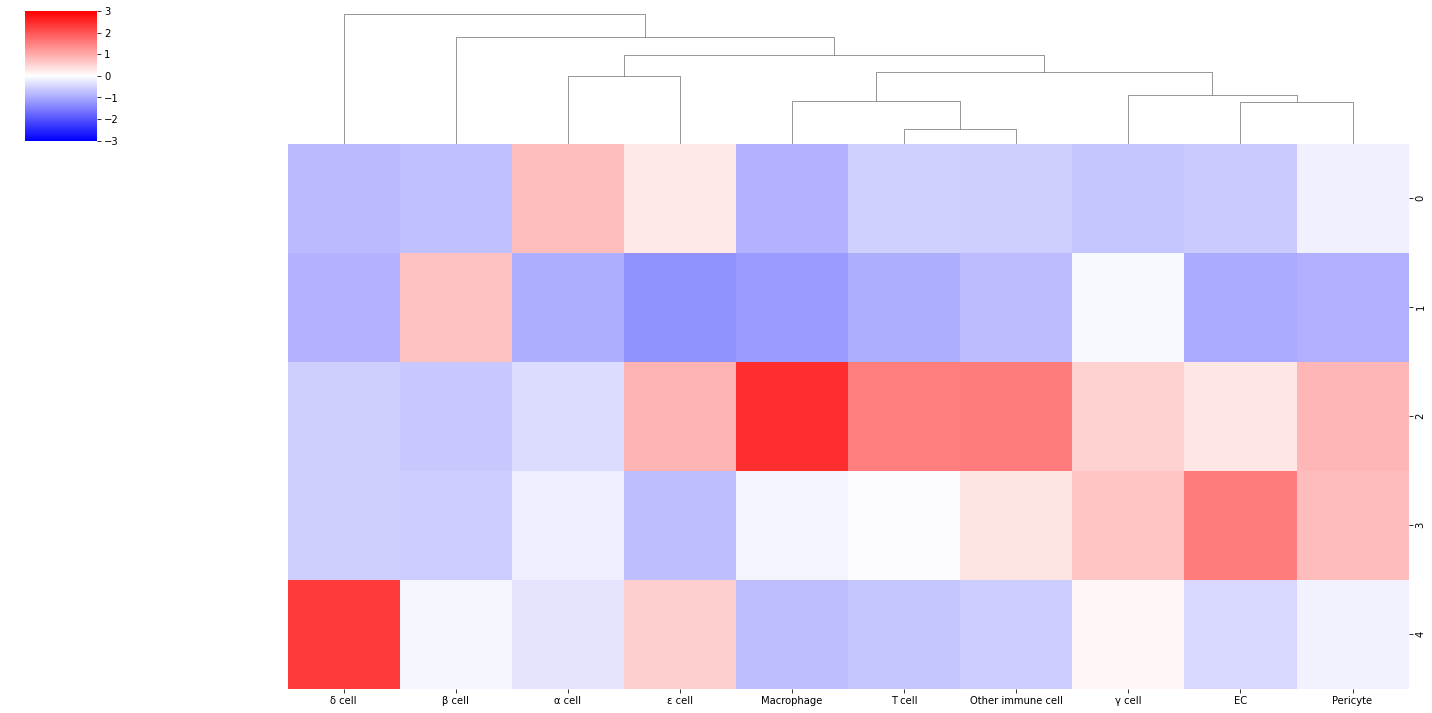

In [11]:
# this plot shows the types of cells (ClusterIDs) in the different niches (0-7)
k_to_plot = k
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis=0)
fc = np.log2(((niche_clusters + tissue_avgs) / (niche_clusters + tissue_avgs).sum(axis=1, keepdims=True)) / tissue_avgs)
fc = pd.DataFrame(fc, columns=sum_cols)
s = sns.clustermap(fc.loc[[i for i in range(k_to_plot)], cell_order], vmin=-3, vmax=3, cmap='bwr', row_cluster=False, figsize=(20, 10))
# s.savefig(f'nb10_cn5_heatmap_normalized_key5.jpg', dpi=200)

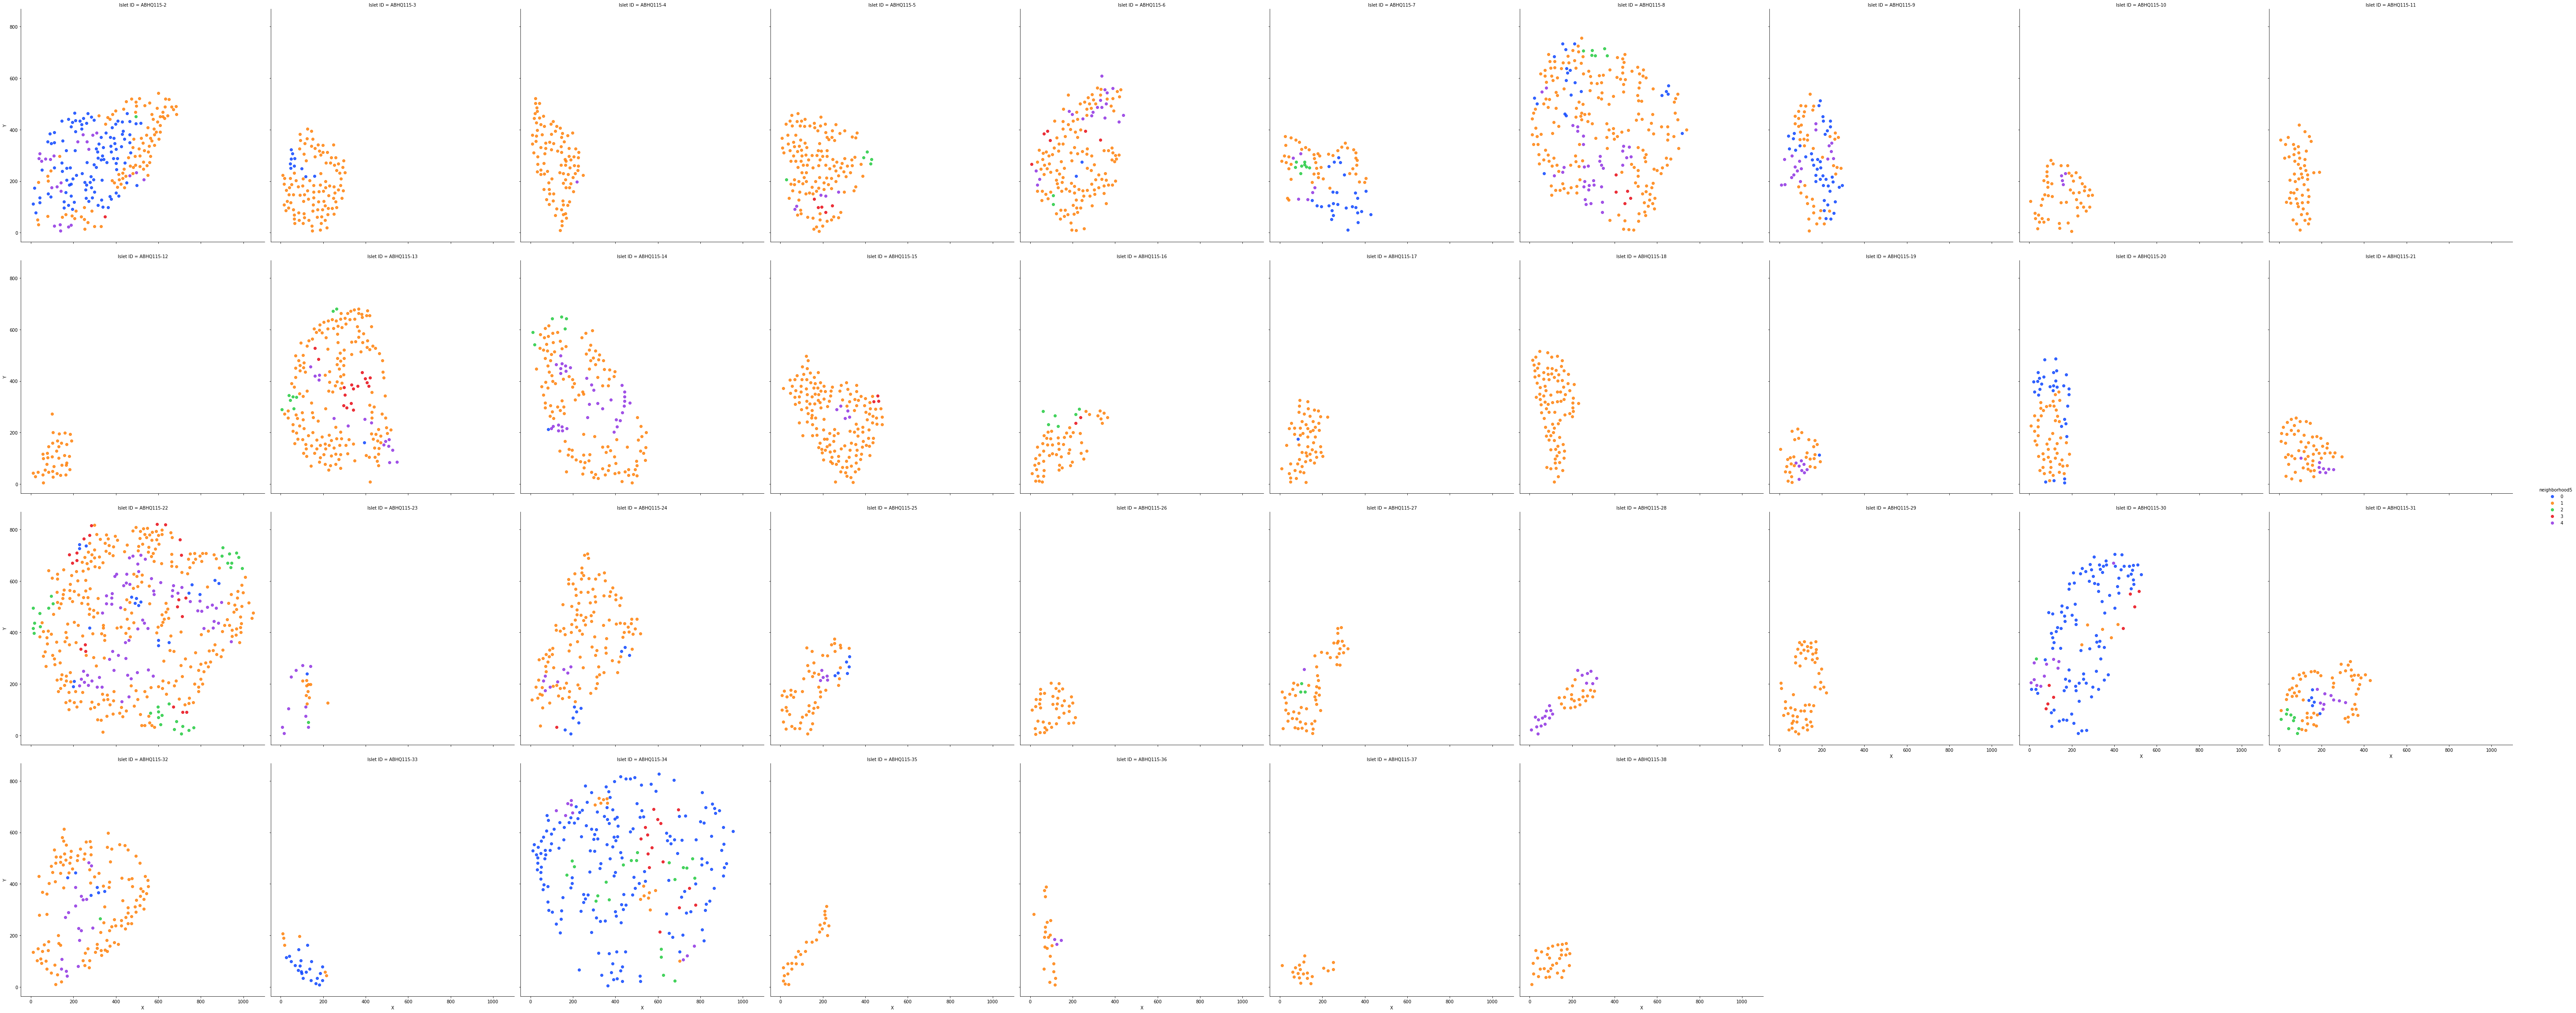

In [12]:
cells[neighborhood_name] = cells[neighborhood_name].astype('category')
sns.lmplot(data=cells[cells['Donor'] == 'ABHQ115'], x='X', y='Y', hue=neighborhood_name, palette='bright', height=8, col=reg, col_wrap=10, fit_reg=False)

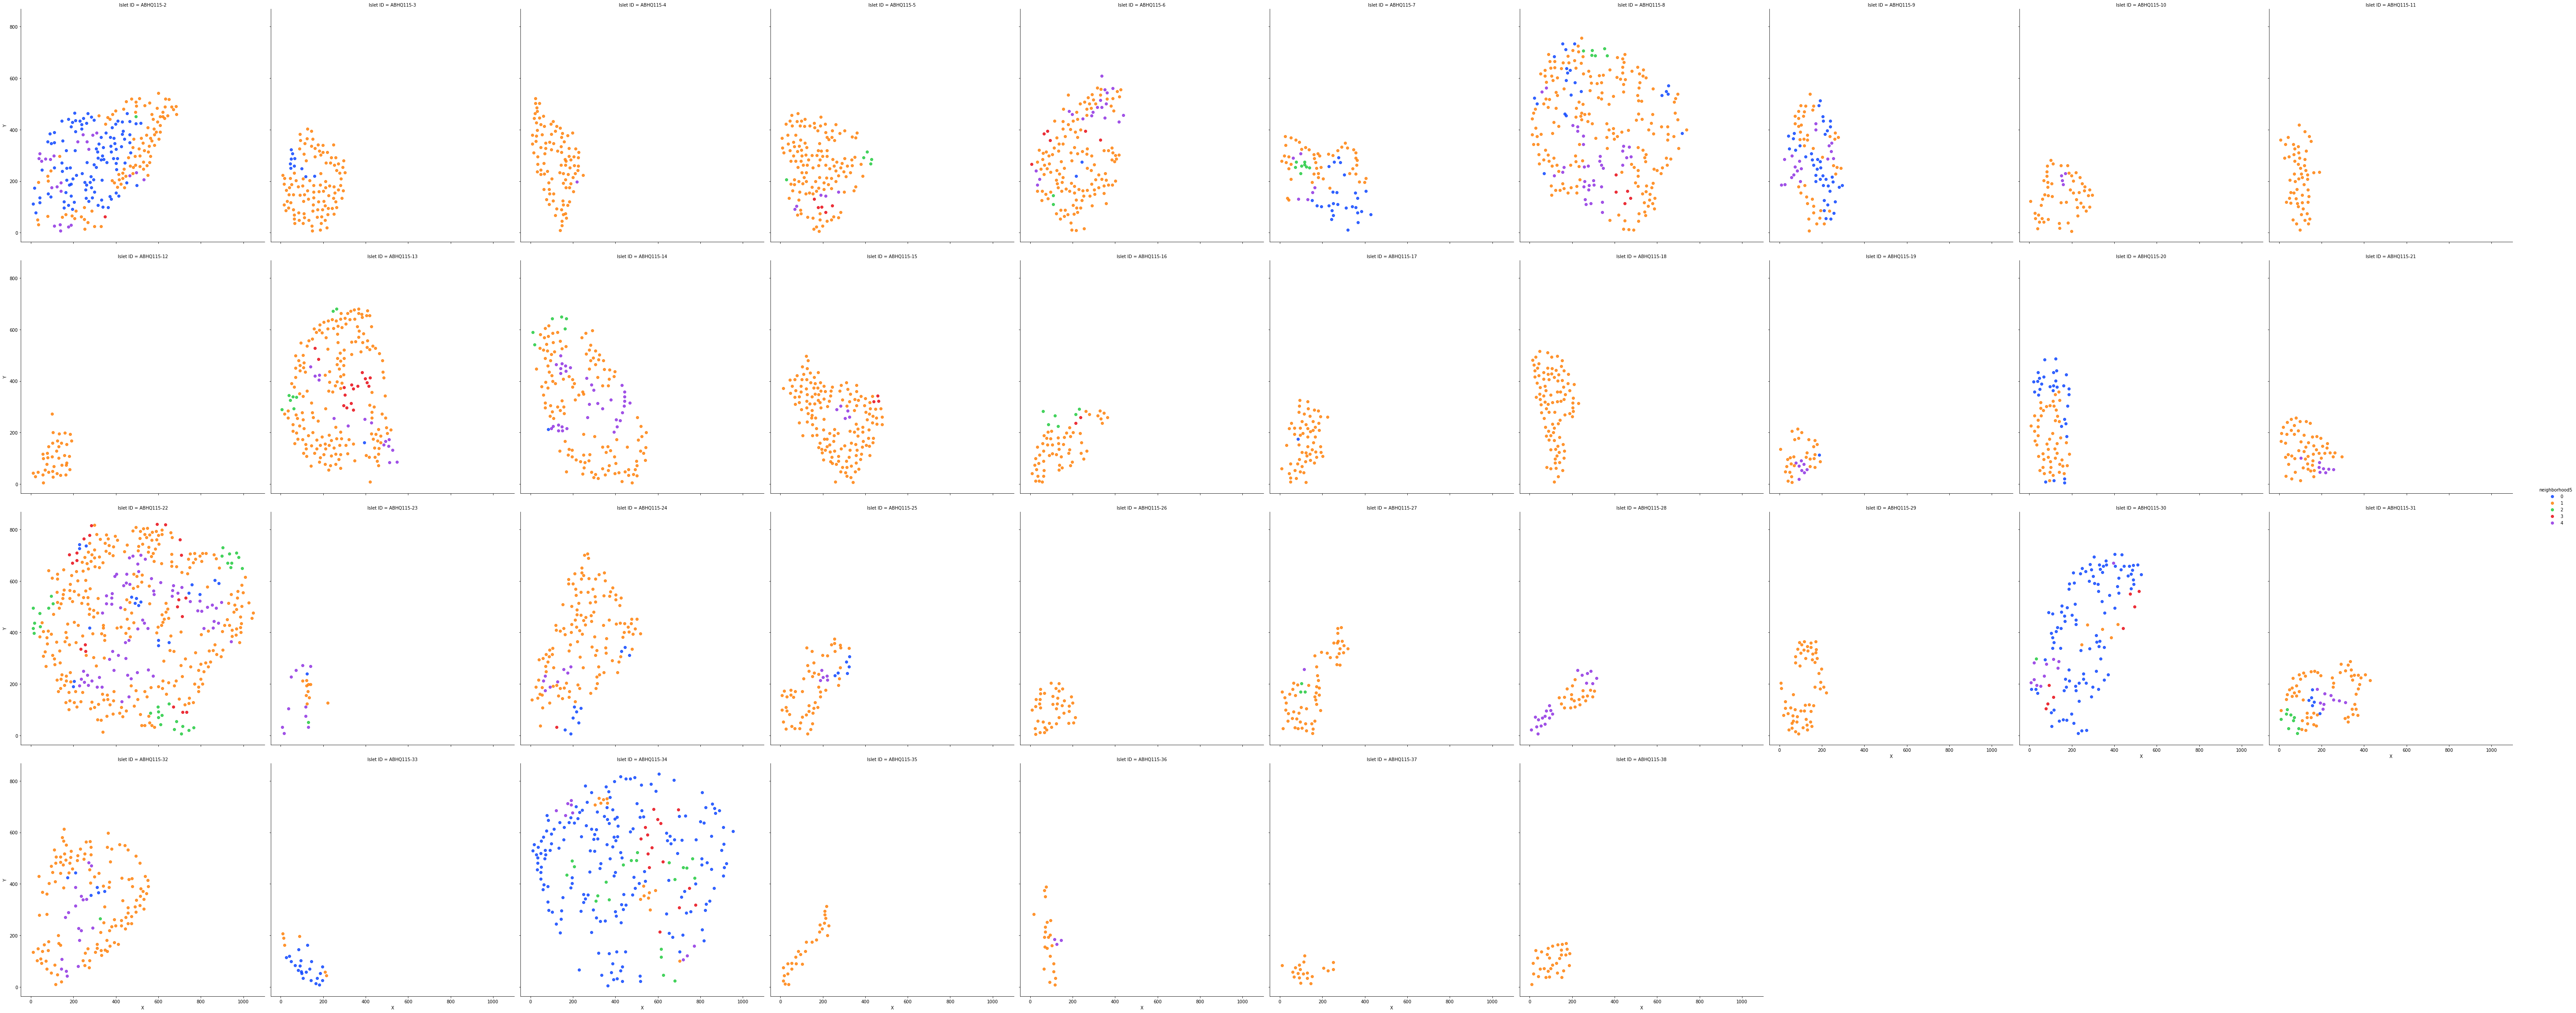

In [13]:
cells[neighborhood_name] = cells[neighborhood_name].astype('category')
sns.lmplot(data=cells[cells['Donor'] == 'ABHQ115'], x='X', y='Y', hue=neighborhood_name, palette='bright', height=8, col=reg, col_wrap=10, fit_reg=False)

In [14]:
# cells.to_csv(f'cleaned_cell_10_normalized_cosine_key5.csv', index=False, encoding='utf-8-sig')